In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import utils.plot as pu

In [ ]:
# Solve the constraint by finding roots of the polynomial
# P(x) = 1 - x + l1*x^5 + l2*x^5*(1 - l1*(1 - kappa)*x^4)^5 == 0

def get_roots(l1, l2, kappa):      

    # safeguard
    if l1 == 0 and l2 == 0:
        root = 1.0
        condition_val = 1 - l1 * (root**4) 
        if condition_val > 0:
            return [0.0]
        
    coeffs = np.zeros(26)
    C = l1 * (1 - kappa)
    
    coeffs[0] = -l2 * (C**5)     
    coeffs[4] = l2 * 5 * (C**4)  
    coeffs[8] = -l2 * 10 * (C**3)
    coeffs[12] = l2 * 10 * (C**2)
    coeffs[16] = -l2 * 5 * C     
    coeffs[20] = l1 + l2         
    coeffs[24] = -1              
    coeffs[25] = 1

    roots = np.roots(coeffs)

    # filter out complex roots and those that do not satisfy the condition
    # 1 - l1 * (x**4) > 0 (the conformal factor must be positive and non-increasing)
    valid_roots = []
    for complex_root in roots:
        if np.isclose(np.imag(complex_root), 0):
            real_root = np.real(complex_root)
            if real_root > 1e-9:
                condition_val = 1 - l1 * (real_root**4)
                if condition_val > 1e-9:
                    valid_roots.append(real_root)

    if not valid_roots:
        return []

    results = []
    for root in valid_roots:
        term1 = l1 / kappa
        base_val = 1 + (root**4) * (kappa - 1) * l1
        term2_base_pow5 = base_val**5
        term2 = l2 * (root**5) * term2_base_pow5
        result = 2 * (term1 + term2)
        results.append(result)
 
    return sorted(list(set(results)))

In [ ]:
# prepare the grid of l1 and l2 values
size       = 300
l1_vals    = np.logspace(-7, 1, size)
l2_vals    = np.logspace(-7, 1, size)

# prepare the kappa values
kappa_values = np.flip([0.001, 0.05, 0.3, 0.999])

# compute the number of solutions for each pair of l1 and l2 values, for each kappa
results_arr = []
for kappa in kappa_values:
    res = np.zeros((size, size), dtype=int)
    for i, l1 in enumerate(l1_vals):
        for j, l2 in enumerate(l2_vals):
            res[i, j] = len(get_roots(l1, l2, kappa)) # count the number of solutions
    results_arr.append(res)

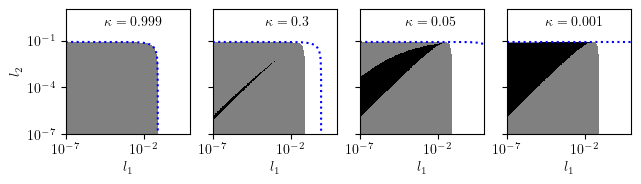

In [ ]:
# plot the results

vmin, vmax   = 0, 4
boundaries   = np.arange(vmin - 0.5, vmax + 1.5, 1)
ticks        = np.arange(vmin, vmax + 1)
cmap         = plt.get_cmap("gray_r", len(ticks))
norm         = BoundaryNorm(boundaries, ncolors=cmap.N)

width = pu.textwidth * pu.cm_to_inch
height = width * pu.golden_ratio

fig, axes = plt.subplots(
    nrows=1, ncols=4,
    sharey=True,
    figsize=(width, height),            
    constrained_layout=True,
    subplot_kw={'aspect': 1}
)

L1, L2 = np.meshgrid(l1_vals, l2_vals, indexing="ij")

for ax, results, kappa in zip(axes, results_arr, kappa_values):
    pcm = ax.pcolormesh(
        L1, L2, results,
        cmap=cmap, norm=norm,
        shading="auto", rasterized=True
    )

    ax.plot(
        l1_vals,
        (4**4 / 5**5) - l1_vals * kappa**2,
        linestyle="dotted", linewidth=1.5, color="blue"
    )
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(l1_vals.min(), l1_vals.max())
    ax.set_ylim(l2_vals.min(), l2_vals.max())
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(plt.LogLocator(base=10, subs="auto"))
    ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs="auto"))
    ax.set_xlabel(r"$l_1$")
    if ax is axes[0]:
        ax.set_ylabel(r"$l_2$")
    ax.set_aspect('equal', adjustable='box')
    ax.text(
        0.77, 0.95,
        rf"$\kappa={kappa:.3g}$",
        transform=ax.transAxes,
        color="black",
        ha="right", va="top"
    )

plt.savefig("img/2dirac_spaces.pdf", bbox_inches="tight", dpi=300)